# COVID-19 Quick Analysis

#### We start with a brief look at some of the first countries outside China to be impacted before turning our attention to the US and Italy. We see how the data in different countries matches with linear, exponential, and logistic growth models.

Data from open-covid-19. Updated March 17, 2020.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

df = pd.read_csv('https://raw.githubusercontent.com/open-covid-19/data/master/output/world.csv')
df.tail()

,Date,CountryCode,CountryName,Confirmed,Deaths,Latitude,Longitude
5317,2020-03-17,VE,Venezuela,33,0,6.423750,-66.589730
5318,2020-03-17,VN,Vietnam,61,0,14.058324,108.277199
5319,2020-03-17,XK,Kosovo,2,0,42.602636,20.902977
5320,2020-03-17,ZA,South Africa,62,0,-30.559482,22.937506
5321,2020-03-18,IT,Italy,31506,2503,41.871940,12.567380


This csv contains data going back to Dec 31. For each day, we see for each country the number of confirmed cases and the number of confirmed deaths, as well as a latitude and longitude for the country. This may be for the geographic center of the country? Let's change the 'Confirmed' and 'Deaths' columns to floats for analysis and make the Date the index.

In [2]:
df['Confirmed'] = df['Confirmed'].astype(float)
df['Deaths'] = df['Deaths'].astype(float)
df = df.set_index('Date')

For now, we're not concerned about the latitude and longitude, and we'd like to focus on data where the number of confirmed cases as risen beyond some threshold. Let's try 15 for now since I remember that number from the news in the US in February.

In [3]:
outbreak_threshold = 15
columns = ['CountryCode', 'CountryName', 'Confirmed', 'Deaths']
outbreak_df = df[df['Confirmed'] > outbreak_threshold][columns]
outbreak_df[outbreak_df['CountryCode'] != 'CN'][columns].head(20)

,CountryCode,CountryName,Confirmed,Deaths
Date,,,,
2020-02-01,SG,Singapore,16.0,0.0
2020-02-01,TH,Thailand,19.0,0.0
2020-02-02,JP,Japan,19.0,0.0
2020-02-02,SG,Singapore,18.0,0.0
2020-02-02,TH,Thailand,19.0,0.0
2020-02-03,JP,Japan,20.0,0.0
2020-02-03,SG,Singapore,18.0,0.0
2020-02-03,TH,Thailand,19.0,0.0
2020-02-04,JP,Japan,20.0,0.0


We see the outbreaks outside of China starting to grow at the beginning of February. Let's take a look at these first countries: Singapore, Thailand, and Japan. Then we'll look at South Korea which now famously took a different course.

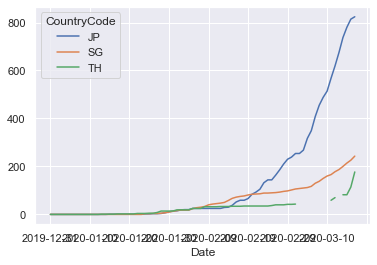

In [4]:
codes = ['SG', 'TH', 'JP']
early_df = df[df['CountryCode'].isin(codes)]
early_confirmed = early_df.pivot(columns='CountryCode', values='Confirmed')
early_confirmed.plot()

As was widely reported, we see that Singapore has kept the outbreak relatively contained, althought we might want to take a closer look at the recent steeper incline. Thailand appears to be missing some data, and the news of 3/15/2020 says there's been a sudden jump in confirmed cases. We'll check back on Thailand in a couple days. Meanwhile, let's see if Singapore is still experiencing merely linear growth for the last ten days.

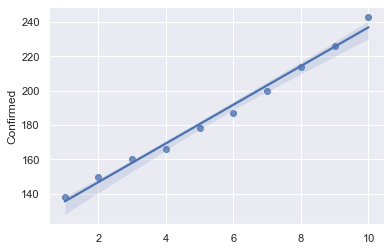

In [5]:
y = df[df['CountryCode'] == 'SG']['Confirmed'].tail(10)
x = np.linspace(1, 10, num=10)
sns.regplot(x,y)

Looks like Singapore has it under control even if there was an increase in the number of new cases per day starting a couple weeks ago. Now let's look closer at Japan.

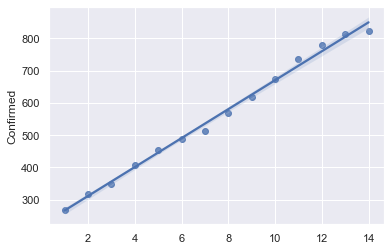

In [6]:
y = df[df['CountryCode'] == 'JP']['Confirmed'].tail(14)
x = np.linspace(1, 14, num=14)
sns.regplot(x,y)

Although Japan has many more cases than Singapore, on March 15, it appeared to growing at a roughly linear rate, which was very encouraging. The most recent data as of March 17 appears to show it leveling off. Let's move on to South Korea, which we left out above.

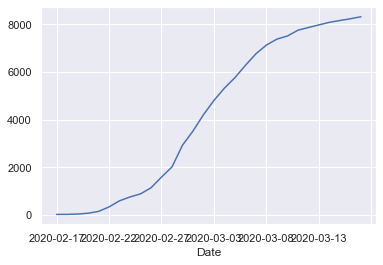

In [7]:
korea_df = df[df['CountryCode'] == 'KR']['Confirmed'].tail(30)
korea_df.plot()

That definitely does not look linear. In fact, it looks like the confirmed cases went through a period of exponential growth, but it looks over all like the classic logistic curve. Let's see if we can fit it to that model.

[1.39223448e+02 3.26196503e-01 8.22483788e+03]


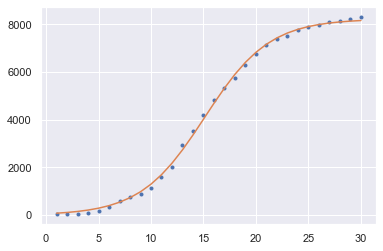

In [8]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def sigmoid(x, a, b, c):
     y = c / (1 + a*np.exp(-b*x))
     return y

x = np.linspace(1, 30, num=30)
popt, pcov = curve_fit(sigmoid, x, korea_df)
plt.plot(x, korea_df, '.', x, sigmoid(x,*popt), '-')
print(popt)

Now, let's take a look closer to home for the author: The US. The last 3 weeks has felt very intense, so let's take a look.

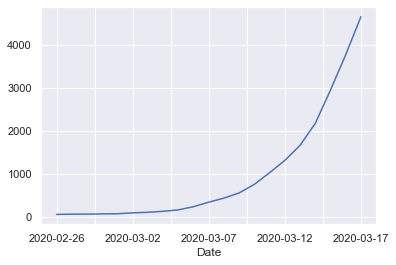

In [9]:
us_df = df[df['CountryCode'] == 'US']['Confirmed']
us_df.tail(21).plot()

It looked a lot like exponential growth on March 15, but the rate might be slowing as of March 17, which could be a sign that social distancing is starting to help. That sure looks like exponential growth. Let's fit an exponential curve and then maybe compare to another country having a crisis: Italy.

[20.51910584  0.25946524]


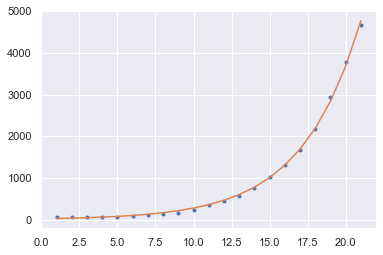

In [10]:
def exponential(x, c, r):
    y = c*np.exp(r*x)
    return y

x = np.linspace(1, 21, num=21)
y = us_df.tail(21)
popt, pcov = curve_fit(exponential, x, y)
plt.plot(x, y, '.', x, exponential(x,*popt), '-')
print(popt)

Let's extrapolate to predict the week of growth assuming that the rate of spread does not decrease. 

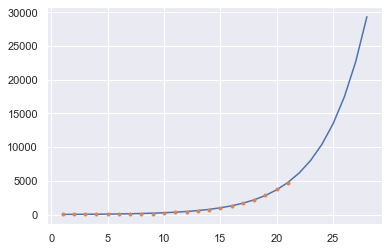

In [11]:
x = np.linspace(1, 28, num=28)
plt.plot(x, exponential(x,*popt), '-')
x1 = np.linspace(1, 21, num=21)
y1 = us_df.tail(21)
plt.plot(x1, y1, '.')

That's spooky! So that I feel a little showing this to family and friends, I'm going to make a plot of the growth rates that would have been measure over the last week or so and look for a trend. 

0.2713704460259063


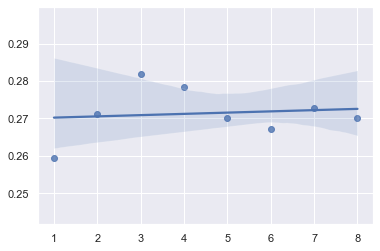

In [12]:
growth_rates = []
x = np.linspace(1, 21, num=21)
N=8
for i in range(N):
    y = us_df.iloc[-(N-i)-21:-(N-i)]
    popt, pcov = curve_fit(exponential, x, y)
    growth_rates.append(popt[1])
xr = np.linspace(1, N, num=N)
yr = np.array(growth_rates)
sns.regplot(xr,yr)
print(yr.mean())

Looks like the growth rate has  started to settle down the last week or so. Let's call it 0.27. For reference, let's look closer at Italy, whose confirmed cases have overwhelmed its health care system.

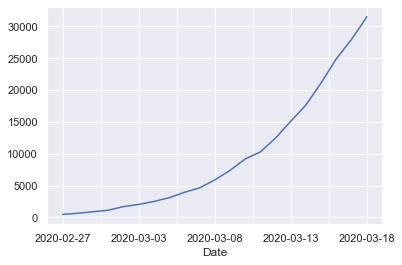

In [13]:
it_df = df[df['CountryCode'] == 'IT']['Confirmed']
it_df.tail(21).plot()

So in just one week, we might be where Italy is now in terms of number of confirmed cases. Of course, the population, geography, and politics of the US are very different. Let's check the parameters of the exponential growth. We'll also want to try to take recovery into account soon.

[9.82340708e+02 1.67667526e-01]


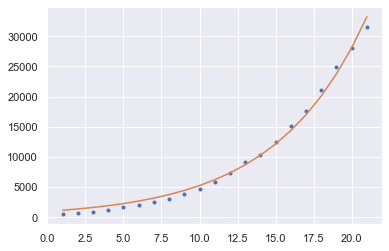

In [14]:
x = np.linspace(1, 21, num=21)
y = it_df.tail(21)
popt, pcov = curve_fit(exponential, x, y)
plt.plot(x, y, '.', x, exponential(x,*popt), '-')
print(popt)

Let's look at the growth rates again. Note to self: let's make this a nice function that we can apply over many countries for comparison

0.2108472599887086


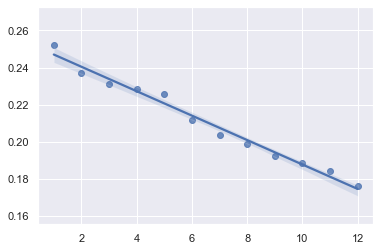

In [15]:
growth_rates_it = []
x = np.linspace(1, 21, num=21)
N=12
for i in range(N):
    y = it_df.iloc[-(N-i)-21:-(N-i)]
    popt, pcov = curve_fit(exponential, x, y)
    growth_rates_it.append(popt[1])
xr = np.linspace(1, N, num=N)
yr = np.array(growth_rates_it)
sns.regplot(xr,yr)
print(yr.mean())

In [16]:
it_df.tail()

Date
2020-03-14    17660.0
2020-03-15    21157.0
2020-03-16    24938.0
2020-03-17    27980.0
2020-03-18    31506.0
Name: Confirmed, dtype: float64

In Italy, the growth rate is clearly decreasing, a sign that the shutdown is working. In addition, the current rate of about 0.17 compared to the US with about 0.26 is troubling since our social distancing measures are nowhere near those that Italy used to reduce the spread. For reference, the doubling time given an exponential growth rate is $t_2 = \frac{\ln 2}{r}$ which for the US in hours gives $t_2 \approx 24\frac{0.693}{0.26} = 61.6$ hours.

Just for visualization, let's optimistically suppose that the growth rate in Italy continues to decrease over the next week. For our toy model, let's suppose the growth rate satisfied $0.17 - 0.005t$ where $t$ is in days since it looked like it went from $0.18$ to $0.17$ in two days. Then using the simplistic assumption that the rate of change is proportional to the current population $P$, we get the differential equation becomes $\frac{dP}{dt} = (0.17 - 0.005t)P$. This separable equation can be solved with Calculus II methods: $\int \frac{1}{P} dP = \int (0.17 - 0.005t) dt$ which gives $\ln P = 0.17t - 0.0025t^2 + C$ and hence $P(t) = P(0)e^{0.17t - 0.0025t^2}$. Putting in $P(0) = 31506$, we have the following plot. 

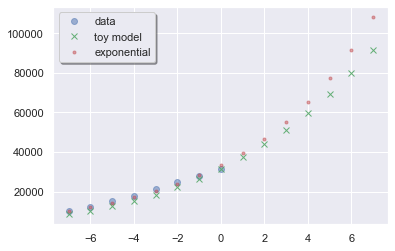

In [17]:
x1 = np.linspace(-7, 0, num=8)
x2 = np.linspace(-7, 7, num=15)
popt = [982, 0.168]
def toy_model(t, p0=31506, r0=0.17, q=0.005):
    y = p0*np.exp(r0*t - (q/2)*t**2)
    return y

fig, ax = plt.subplots()
ax.plot(x1, it_df.tail(8),'bo', label='data', alpha=0.5)
ax.plot(x2, toy_model(x2),'gx', label='toy model', alpha=0.9)
ax.plot(x2,popt[0]*np.exp(popt[1]*(x2+21)), 'r.', label='exponential', alpha=0.5)
legend = ax.legend(loc='upper left', shadow=True)

Both models seem reasonable for the data of the last week, but let's hope the toy model is better than the exponential! If we're being very optimistic, we hope that an inflection point happens and logistic behavior takes over. Let's use the toy model to project what the number of cases will be in a couple days and then assume that's the inflection point which would give us a carrying capacity of double that number. We'll take as an initial population whatever we started with three weeks ago.

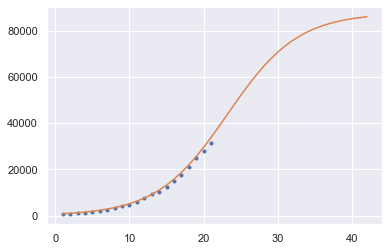

In [18]:
x1 = np.linspace(1, 21, num=21)
y1 = it_df.tail(21)
x2 = np.linspace(1, 42, num=42)
K = 2*toy_model(2)
P = it_df.iloc[-20]
L = (K-P)/P
r = yr.mean()
plt.plot(x1, y1, '.', x2, sigmoid(x2,L,r,K), '-')

That looks surprisingly good! Let's hope this is closer to what's happening in Italy.

I'll update and expand this tomorrow, March 18th. I had a lot of things to take care of yesterday and today, so I only had time for a minor update.